# Fit emimTF2N data

EoS: PR

Parameter T dependence: Constant

N (total fitting parameters): 2

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest
from bip_fitting_functions import constant

import scipy.stats as stats

## Load Data

In [2]:
#FILLIN: change data file
data_subset = pd.read_csv('r32_emimtf2n_subset.csv')

## Load Configuration + Check DOF 

In [3]:
#FILLIN: change configuration file
from hfc32_emimtf2n_PR import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

In [5]:
#FILLIN: change component names, change init_kappa values to find good initial point

parameters, obj_value, a = constant(data_subset, configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
        init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
        init_kappa_A_2_1 = -0.294291, init_kappa_A_1_2 = -0.08582, #FILLIN: may need to change these to initialize
        eps = 0.1, scaling_fac = 1e-9, 
        filename='Data/Ipopt_Output/PR_noTdep_final.txt')

2022-08-31 14:16:16 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-08-31 14:16:18 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-08-31 14:16:20 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-08-31 14:16:20 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-08-31 14:16:21 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-08-31 14:16:22 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-08-31 14:16:23 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-08-31 14:16:24 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-08-31 14:16:25 [INFO] idaes

/Users/bridgettebefort/opt/anaconda3/envs/idaes-pse-dev/lib/python3.9/site-packages/pyomo/contrib/interior_point/interface.py:418: RuntimeWarning: divide by zero encountered in true_divide
  data = (duals_primals_lb/(primals - self._nlp.primals_lb()) +


In [6]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.6526637302428189


In [7]:
print('Parameters:',parameters)

Parameters: fs.properties.PR_kappa_A[emimTf2N,R32]   -0.200947
fs.properties.PR_kappa_A[R32,emimTf2N]   -0.056196
dtype: float64


In [8]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[3.66990409e-04 3.31181344e-05]
 [3.31181344e-05 4.59347392e-06]]


## Apply Parameters + Plot + Predict

In [9]:
# Define solver options
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

### Plot

In [10]:
# Build out idaes model
#FILLIN: change data file, names of components
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5) #FILLIN: change component name

m.fs.properties.PR_kappa_A['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'] #FILLIN: change component name
m.fs.properties.PR_kappa_A['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'] #FILLIN: change component name

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix() #FILLIN: change component name

R32_x = np.zeros((len(data_subset))) #FILLIN: change data file, component name
P = np.zeros((len(data_subset))) #FILLIN: change data file
T = np.zeros((len(data_subset))) #FILLIN: change data file

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq) #FILLIN: change component name

for i in range(len(data_subset)): #FILLIN: change data file
    print('i:',i)
    print('Try x_IL:',data_subset["x_emimTf2N"].iloc[i]) #FILLIN: change data file, component name
    m.fs.liq = data_subset["x_emimTf2N"].iloc[i] #FILLIN: change data file, component name
    m.fs.F101.inlet.temperature.fix(float(data_subset["temperature"].iloc[i])) #FILLIN: change data file
    m.fs.F101.inlet.pressure.fix(float(data_subset["pressure"].iloc[i])) #FILLIN: change data file
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_subset["x_R32"].iloc[i])+0.1) #FILLIN: change data file, component name
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_subset["x_R32"].iloc[i]+0.1))) #FILLIN: change data file, component name
    m.fs.F101.vap_outlet.temperature.fix(float(data_subset["temperature"].iloc[i])) #FILLIN: change data file
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
    except:
        print('Initialization Error')
        
    try:
        
        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print('Feasible/Optimal Solution')
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) #FILLIN: change data file, component name
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
            T[i] = data_subset["temperature"].iloc[i] #FILLIN: change data file
        else:
            print('Infeasible Solution')
            R32_x[i] = np.nan #FILLIN: change data file, component name
            P[i] = np.nan
            T[i] = data_subset["temperature"].iloc[i] #FILLIN: change data file

    except ValueError:
        R32_x[i] = np.nan #FILLIN: change data file, component name
        P[i] = np.nan
        T[i] = data_subset["temperature"].iloc[i] #FILLIN: change data file
        print('Solver Error')

i: 0
Try x_IL: 0.864
Feasible/Optimal Solution
i: 1
Try x_IL: 0.694
Feasible/Optimal Solution
i: 2
Try x_IL: 0.552
Feasible/Optimal Solution
i: 3
Try x_IL: 0.43
Feasible/Optimal Solution
i: 4
Try x_IL: 0.328
Feasible/Optimal Solution
i: 5
Try x_IL: 0.214
Feasible/Optimal Solution
i: 6
Try x_IL: 0.905
Feasible/Optimal Solution
i: 7
Try x_IL: 0.782
Feasible/Optimal Solution
i: 8
Try x_IL: 0.675
Feasible/Optimal Solution
i: 9
Try x_IL: 0.583
Feasible/Optimal Solution
i: 10
Try x_IL: 0.501
Feasible/Optimal Solution
i: 11
Try x_IL: 0.43
Feasible/Optimal Solution
i: 12
Try x_IL: 0.357
Feasible/Optimal Solution
i: 13
Try x_IL: 0.945
Feasible/Optimal Solution
i: 14
Try x_IL: 0.867
Feasible/Optimal Solution
i: 15
Try x_IL: 0.8
Feasible/Optimal Solution
i: 16
Try x_IL: 0.736
Feasible/Optimal Solution
i: 17
Try x_IL: 0.68
Feasible/Optimal Solution
i: 18
Try x_IL: 0.632
Feasible/Optimal Solution
i: 19
Try x_IL: 0.583
Feasible/Optimal Solution
i: 20
Try x_IL: 0.966
Feasible/Optimal Solution
i: 21
T

In [11]:
fitted_data = pd.DataFrame(data=[R32_x,P/1e6,T])  #FILLIN: change component name
fitted_data = fitted_data.T
fitted_data.columns = ['R32_x','P, MPa','T, K']  #FILLIN: change component name

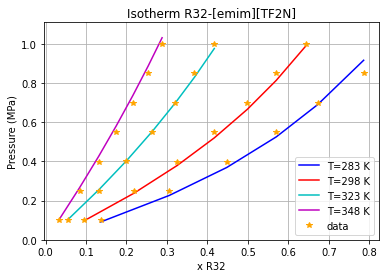

In [12]:
 #FILLIN: change component name
plt.plot(fitted_data.where(fitted_data['T, K']==283.15)['R32_x'],fitted_data.where(fitted_data['T, K']==283.15)['P, MPa'],"b-",label='T=283 K')
plt.plot(fitted_data.where(fitted_data['T, K']==298.15)['R32_x'],fitted_data.where(fitted_data['T, K']==298.15)['P, MPa'],"r-",label='T=298 K')
plt.plot(fitted_data.where(fitted_data['T, K']==323.15)['R32_x'],fitted_data.where(fitted_data['T, K']==323.15)['P, MPa'],"c-",label='T=323 K')
plt.plot(fitted_data.where(fitted_data['T, K']==348.05)['R32_x'],fitted_data.where(fitted_data['T, K']==348.05)['P, MPa'],"m-",label='T=348 K')
 #FILLIN: change data file, component name
plt.plot(data_subset["x_R32"],data_subset["pressure"]/1e6,"*",color='orange',label="data")  
 #FILLIN: change component name
plt.title('Isotherm R32-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
 #FILLIN: change component name
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Evaluate at specific points

In [13]:
# Set up dataframe of new points to evaluate - you will need to guess pressure/compositions
#FILLIN: change names of components
eval_points = {'temperature':[298.15,298.15],'pressure':[400000,500000],'x_R32':[0.35,0.375],'x_emimTf2N':[0.65,0.625]}
new_data = pd.DataFrame(data=eval_points)
new_data

,temperature,pressure,x_R32,x_emimTf2N
0,298.15,400000,0.350,0.650
1,298.15,500000,0.375,0.625


In [14]:
# Build out idaes model
#FILLIN: change names of components
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5) #FILLIN: change component name

m.fs.properties.PR_kappa_A['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'] #FILLIN: change component name
m.fs.properties.PR_kappa_A['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'] #FILLIN: change component name

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix() #FILLIN: change component name

R32_x = np.zeros((len(new_data))) #FILLIN: change component name
P = np.zeros((len(new_data))) 
T = np.zeros((len(new_data))) 

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq) #FILLIN: change component name

for i in range(len(new_data)): 
    print('i:',i)
    print('Try x_IL:',new_data["x_emimTf2N"].iloc[i]) #FILLIN: change component name
    m.fs.liq = new_data["x_emimTf2N"].iloc[i] #FILLIN: change component name
    m.fs.F101.inlet.temperature.fix(float(new_data["temperature"].iloc[i])) 
    m.fs.F101.inlet.pressure.fix(float(new_data["pressure"].iloc[i])) 
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(new_data["x_R32"].iloc[i])+0.1) #FILLIN: change component name
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(new_data["x_R32"].iloc[i]+0.1))) #FILLIN: change component name
    m.fs.F101.vap_outlet.temperature.fix(float(new_data["temperature"].iloc[i]))
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
    except:
        print('Initialization Error')
        
    try:
        
        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print('Feasible/Optimal Solution')
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) #FILLIN: change component name
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
            T[i] = new_data["temperature"].iloc[i]
        else:
            print('Infeasible Solution')
            R32_x[i] = np.nan #FILLIN: change data file, component name
            P[i] = np.nan
            T[i] = new_data["temperature"].iloc[i] 

    except ValueError:
        R32_x[i] = np.nan #FILLIN: change component name
        P[i] = np.nan
        T[i] = new_data["temperature"].iloc[i]
        print('Solver Error')

i: 0
Try x_IL: 0.65
Feasible/Optimal Solution
i: 1
Try x_IL: 0.625
Feasible/Optimal Solution


In [15]:
fitted_new_data = pd.DataFrame(data=[R32_x,P/1e6,T]) #FILLIN: change component name
fitted_new_data = fitted_new_data.T
fitted_new_data.columns = ['R32_x','P, MPa','T, K'] #FILLIN: change component name

In [16]:
fitted_new_data

,R32_x,"P, MPa","T, K"
0,0.350,0.415379,298.15
1,0.375,0.453215,298.15
